This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from vae import VAE5, loss_function_vae
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs, load_cache_data
from helpers.samplers import SequenceInChunkSampler
from rnn import MDNRNN

# Init

In [32]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 3



# RNN
action_dim = 12
seq_len = 6
image_size=256
chunksize=seq_len*200

# VAE loss function
gamma = 0.25
C = 0

# loss function weights
lambda_vae = 1/12000
lambda_finv = 1/20

data_cache_file = '/data/tmp/sonic_rnn_256.hdf5'

# Load Data

In [5]:
# # load as dask array
# import gc


# def load_cache_data(basedir='/data/vae', env_name='sonic256', data_cache_file='/tmp/sonic_vae.hdf5', image_size=256, chunk_size=10, action_dim=12):
#     filenames = sorted(glob.glob(os.path.join(basedir, 'obs_data_' + env_name + '_*.npz')))
#     filenames_actions = sorted(glob.glob(os.path.join(basedir, 'action_data_' + env_name + '_*.npz')))
#     filenames_rewards = sorted(glob.glob(os.path.join(basedir, 'reward_data_' + env_name + '_*.npz')))
#     filenames_dones = sorted(glob.glob(os.path.join(basedir, 'done_data_' + env_name + '_*.npz')))
#     assert len(filenames)==len(filenames_actions)
#     assert len(filenames)==len(filenames_rewards)
#     assert len(filenames)==len(filenames_dones)

#     if not os.path.isfile(data_cache_file):
#         data_train = load_npzs(filenames, shuffle=False)
#         print(data_train)
#         with TQDMDaskProgressBar():
#             da.to_hdf5(data_cache_file, '/x', data_train)

#         y_train = load_npzs(filenames_actions, shuffle=False)
#         with TQDMDaskProgressBar():
#             da.to_hdf5(data_cache_file, '/actions', y_train)

#         r_train = load_npzs(filenames_rewards, shuffle=False)
#         with TQDMDaskProgressBar():
#             da.to_hdf5(data_cache_file, '/rewards', r_train)

#         d_train = load_npzs(filenames_dones, shuffle=False)
#             with TQDMDaskProgressBar():
#                 da.to_hdf5(data_cache_file, '/dones', d_train)

#         del y_train, data_train, r_train, d_Train
#         gc.collect()
        
#     # load
#     observations = da.from_array(h5py.File(data_cache_file, mode='r')['observations'], chunks=(chunksize, image_size, image_size, 3))
#     actions = da.from_array(h5py.File(data_cache_file, mode='r')['actions'], chunks=(chunksize, action_dim))
#     rewards = da.from_array(h5py.File(data_cache_file, mode='r')['rewards'], chunks=(chunksize, 1))
#     dones = da.from_array(h5py.File(data_cache_file, mode='r')['dones'], chunks=(chunksize, 1))
#     data
#     data_split = int(len(observations)*0.8)
#     observations_train = observations[:data_split]
#     observations_test = observations[data_split:]
#     actions_train = actions[:data_split]
#     actions_test = actions[data_split:]
#     actions_train = actions[:data_split]
#     actions_test = actions[data_split:]
#     data_train.shape, actions_train.shape, data_test.shape, actions_test.shape
    
#     # put cached data into pytorch loaders
#     dataset_train = NumpyDataset(observations[:data_split], actions[:data_split], rewards[:data_split], dones[:data_split])
#     loader_train = torch.utils.data.DataLoader(
#         dataset_train, 
#         sampler=SequenceInChunkSampler(dataset_train, seq_len=seq_len, chunksize=chunksize),
#         pin_memory=True, 
#         shuffle=False, 
#         batch_size=batch_size*seq_len, 
#         drop_last=True
#     )

#     dataset_test = NumpyDataset(observations[data_split:], actions[data_split:], rewards[data_split:], dones[data_split:])
#     loader_test = torch.utils.data.DataLoader(
#         dataset_test, 
#         sampler=SequenceInChunkSampler(dataset_test, seq_len=seq_len, chunksize=chunksize),
#         pin_memory=True, 
#         shuffle=False, 
#         batch_size=batch_size*seq_len, 
#         drop_last=True
#     )

#     return loader_train, loader_test

In [ ]:
loader_train, loader_test = load_cache_data(
    basedir='/data/vae', 
    env_name='sonic256', 
    data_cache_file=data_cache_file, 
    image_size=image_size, 
    chunk_size=chunk_size, 
    action_dim=action_dim)
loader_train, loader_test

(<helpers.dataset.NumpyDataset at 0x7fd17bc46d68>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd17bc46e48>)

# Load VAE

In [29]:
# Load VAE
vae = VAE5(image_size=image_size, z_dim=128, conv_dim=64, code_dim=8, k_dim=512)
if cuda:
    vae.cuda()
    
# # Resume
NAME='RNN_v3b_256im_512z_1024h'

checkpoint_file = f'./models/RNN_v3b_256im_512z-joint-training_state_dict.pkl'
if os.path.isfile(checkpoint_file):
    state_dict = torch.load(checkpoint_file)
    vae.load_state_dict(state_dict)
    print(f'loaded checkpoint_file {checkpoint_file}')
    
save_file = f'./models/{NAME}-vae_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded save_file {save_file}')

loaded checkpoint_file ./models/RNN_v3b_256im_512z-joint-training_state_dict.pkl


In [9]:
# img = np.random.randn(image_size, image_size, 3)
# gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float()
# if cuda:
#     gpu_img = gpu_img.cuda()
# with TorchSummarizeDf(vae) as tdf:
#     x, mu, logvar = vae.forward(gpu_img)
#     print(x.size())
# #     print(loss_function_vae(x, gpu_img, mu, logvar))
#     x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
#     df = tdf.make_df()
# del img, gpu_img, x, mu, logvar
# df[df.level<2]

torch.Size([1, 3, 256, 256])
Total parameters 21877123
Total trainable parameters 21877123


,name,class_name,input_shape,output_shape,nb_params,level
4,encoder.0,ConvBlock4,"[(-1, 3, 256, 256)]","[(-1, 64, 256, 256)]",1920,1
8,encoder.1,ConvBlock4,"[(-1, 64, 256, 256)]","[(-1, 128, 128, 128)]",131456,1
12,encoder.2,ConvBlock4,"[(-1, 128, 128, 128)]","[(-1, 192, 64, 64)]",393792,1
16,encoder.3,ConvBlock4,"[(-1, 192, 64, 64)]","[(-1, 256, 32, 32)]",787200,1
20,encoder.4,ConvBlock4,"[(-1, 256, 32, 32)]","[(-1, 320, 16, 16)]",1311680,1
24,encoder.5,ConvBlock4,"[(-1, 320, 16, 16)]","[(-1, 384, 8, 8)]",1967232,1
25,encoder.6,Conv2d,"[(-1, 384, 8, 8)]","[(-1, 128, 8, 8)]",49280,1
26,mu,Linear,"[(-1, 8192)]","[(-1, 512)]",4194816,0
27,logvar,Linear,"[(-1, 8192)]","[(-1, 512)]",4194816,0
28,z,Linear,"[(-1, 512)]","[(-1, 8192)]",4202496,0


# Load RNN

In [10]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 512, 12, 1024, 5, 0.0


mdnrnn = MDNRNN(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

In [11]:
# # Resume?
save_file = f'./models/{NAME}-mdnrnn_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(f'./models/{NAME}_state_dict.pkl')
    mdnrnn.load_state_dict(state_dict)
    print(f'loaded {save_file}')

loaded ./models/RNN_v3b_256im_512z_1024h-mdnrnn_state_dict.pkl


In [12]:
# img = np.random.randn(image_size, image_size, 3)
# action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
# gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
# if cuda:
#     gpu_img = gpu_img.cuda()
# with TorchSummarizeDf(mdnrnn) as tdf:
#     x, mu, logvar = vae.forward(gpu_img)
#     z = vae.sample(mu, logvar)
#     mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
#     x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
#     df = tdf.make_df()
    
# del img, action, gpu_img, x, mu, z
# df[df.level<3]

Total parameters 14220800
Total trainable parameters 14220800


,name,class_name,input_shape,output_shape,nb_params,level
1,rnn,LSTM,"[[(-1, 2, 524)], [[(-1, 1, 1024)], [(-1, 1, 10...","[[(-1, 2, 1024)], [[(-1, 1, 1024)], [(-1, 1, 1...",6348800,0
2,mdn,Linear,"[(-1, 1024), (-1, 1024)]","[(-1, 7680), (-1, 7680)]",7872000,0


# Inverse model

In [13]:
class FInv(torch.nn.modules.Module):
    def __init__(self, z_dim, action_dim, hidden_size):
        """
        Inverse model from https://arxiv.org/abs/1804.10689.
        
        Takes in z and z' and outputs predicted action
        """
        super().__init__()
        self.ln1 = nn.Linear(z_dim*2, hidden_size)
        self.ln2 = nn.Linear(hidden_size,  action_dim)
        
    def forward(self, z_now, z_next):
        x = torch.cat((z_now, z_next), dim=-1)
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.softmax(x, -1)
        return x

In [14]:
finv = FInv(z_dim, action_dim, hidden_size=256).cuda()

# Summarize models

In [15]:
img = np.random.randn(image_size, image_size, 3)
action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu_vae, logvar_vae = vae.forward(gpu_img)
    z = vae.sample(mu_vae, logvar_vae)
    df_vae = tdf.make_df()
#     loss_recon, loss_KLD = loss_function_vae(Y, x, mu_vae, sigma_vae)
#     loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
#     loss_vae = loss_vae.mean() # mean along the batches
with TorchSummarizeDf(mdnrnn) as tdf: 
    pi, mu, sigma, hidden_state = mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
    z_next = mdnrnn.sample(pi, mu, sigma)
#     loss_mdn = mdnrnn.rnn_loss(z, pi, mu, sigma).mean()
    df_mdnrnn = tdf.make_df()

#     loss = loss_mdn + gamma_vae * loss_vae
with TorchSummarizeDf(finv) as tdf:
    action_pred = finv(z.repeat((1,2,1)), z_next)
        
    df_finv = tdf.make_df()
    
del img, action, gpu_img, x, mu, z


Total parameters 265484
Total trainable parameters 265484


,name,class_name,input_shape,output_shape,nb_params,level
1,ln1,Linear,"[(-1, 2, 1024)]","[(-1, 2, 256)]",262400,0
2,ln2,Linear,"[(-1, 2, 256)]","[(-1, 2, 12)]",3084,0


In [ ]:
df_vae[df_vae.level<3]

In [ ]:
df_finv

In [ ]:
df_mdnrnn

# Init

In [16]:
class Model(torch.nn.modules.Module):
    def __init__(self, vae, mdnrnn, finv):
        super().__init__()
        self.vae = vae
        self.mdnrnn = mdnrnn
        self.finv = finv
        
model = Model(vae, mdnrnn, finv)

In [17]:

torch.save(finv.state_dict(), f'./models/{NAME}-finv_state_dict.pkl')

In [28]:

import torch.optim.lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# optimizer_vae = optim.Adam(vae.parameters(), lr=3e-5)
# scheduler_vae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vae, mode='min', patience=3, verbose=True)

# Train helpers

In [19]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    vae.eval()
    mdnrnn.eval()
    
    observations, actions = next(iter(loader))
    
    X = Variable(observations.transpose(1,3))
    _, channels, height, width = X.size()
    if cuda:
        X=X.cuda()
    Y, mu_vae, logvar = vae.forward(X)
    loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
    loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
    
    # TODO do we want to sample in test or training mode?
    z_v = vae.sample(mu_vae, logvar)
    
    z_v = z_v.view(batch_size, seq_len, -1)
    Y = Y.view((batch_size, seq_len, channels, height, width))
    X = X.view((batch_size, seq_len, channels, height, width))
    loss_vae = loss_vae.view(batch_size, seq_len, -1)
    actions = actions.view(batch_size, seq_len, -1)
    
    # Forward
    actions_v = Variable(actions).float()
    

    if cuda:
        z_v=z_v.cuda()
        actions_v=actions_v.cuda()
    pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

    loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)
    
    mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
    X_pred = vae.decode(mu)
    X_pred = X_pred.view((batch_size, seq_len, channels, height, width))
    
    # TODO finv    
    
    for i in np.linspace(0,seq_len-2,n):
        batch = np.random.randint(0,batch_size)
        i=int(i)
        y=Y[batch][i].cpu().data.transpose(0,2).numpy()
        x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
        x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
        x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
        loss_vae_i = loss_vae[batch][i].cpu().data.item()
        loss_i = loss[batch].cpu().data.item()
        
        plt.figure(figsize=figsize)
        
        plt.subplot(2, 3, 1)
        plt.axis("off")
        plt.title('original')
        plt.imshow(x_orig)

        plt.subplot(2, 3, 4)
        plt.axis("off")
        plt.imshow(y)
        plt.title('reconstructed')
           
        plt.subplot(2, 3, 2)
        plt.axis("off")
        plt.imshow(x_next)
        plt.title('true next')
        
        plt.subplot(2, 3, 5)
        plt.axis("off")
        plt.imshow(x_pred)
        plt.title('pred next')
        
        plt.subplot(2, 3, 3)
        plt.axis("off")
        plt.imshow(np.abs(x_orig-x_next))
        plt.title('actual changes')
        
        plt.subplot(2, 3, 6)
        plt.axis("off")
        plt.imshow(np.abs(y[i]-x_pred))
        plt.title('predicted changes')

        plt.suptitle('epoch {}, seq index {}, batch={}. vae_loss {:2.4f}, loss {:2.4f}'.format(
            epoch, 
            i,
            batch,
            loss_vae_i, 
            loss_i
        ))
#         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
        plt.show()
        


TODO

- [ ] make a module containing all 3 including inverse model from https://arxiv.org/pdf/1804.10689.pdf
    - that way they can use the same optimizer
- [ ] do dual training

In [20]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            # TODO do we want to sample in test or training mode?
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)
            
            loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches

            # MDNRNN Forward
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len, -1)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            loss_mdn = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
            
            # Finv forward
            z_next = mdnrnn.sample(pi, mu, sigma)
            z_now = z_v.unsqueeze(2).repeat((1, 1, mdnrnn.n_mixture, 1))
            
            action_pred = finv(z_v, z_next)
            loss_inv = ((action_pred-actions_v)**2).sum(-1)
            loss_inv = loss_inv.mean()
            
            loss = loss_mdn + lambda_vae * loss_vae + lambda_finv * loss_inv

            if not test:
                optimizer.step()
                optimizer.zero_grad()

            # Record
            info['loss_inv'].append(loss_inv.cpu().data.numpy())
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            prog.update(loader.batch_size)
            prog.desc='loss_rnn={loss_mdn:2.4f}, loss_inv= {lambda_finv}* {loss_inv:2.4f}, loss_vae={lambda_vae:2.4f} * ({loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}|)'.format(
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                lambda_finv=lambda_finv,
                lambda_vae=lambda_vae,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
                loss_inv=np.mean(info['loss_inv'])
            )
            if i%400==0:
                print('[{}/{}]'.format(i, max_batches), prog.desc)

        print(prog.desc)
        prog.close()

    return info

# Train

In [21]:
max_batches=40000//loader_train.batch_size
max_batches
torch.cuda.empty_cache()

In [22]:
# Load previous history
import pandas as pd
if os.path.isfile(f'./models/{NAME}.csv'):
    histories = pd.read_csv(f'./models/{NAME}.csv').to_dict(orient='records')
else:
    histories = []

[0/2222] loss_rnn=0.3145, loss_inv= 0.05* 2.8604, loss_vae=0.0001 * (2895.68 + 0.25*|70.51 - 0|)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[400/2222] loss_rnn=0.3295, loss_inv= 0.05* 3.0647, loss_vae=0.0001 * (2581.74 + 0.25*|78.02 - 0|)
[800/2222] loss_rnn=0.3544, loss_inv= 0.05* 3.0673, loss_vae=0.0001 * (2615.80 + 0.25*|80.89 - 0|)
[1200/2222] loss_rnn=0.3628, loss_inv= 0.05* 3.0714, loss_vae=0.0001 * (2579.26 + 0.25*|80.63 - 0|)
[1600/2222] loss_rnn=0.3538, loss_inv= 0.05* 3.0717, loss_vae=0.0001 * (2557.66 + 0.25*|79.87 - 0|)
[2000/2222] loss_rnn=0.3645, loss_inv= 0.05* 3.0701, loss_vae=0.0001 * (2601.08 + 0.25*|80.36 - 0|)
loss_rnn=0.3661, loss_inv= 0.05* 3.0693, loss_vae=0.0001 * (2598.39 + 0.25*|80.41 - 0|)



[0/370] loss_rnn=0.3821, loss_inv= 0.05* 2.9986, loss_vae=0.0001 * (2279.61 + 0.25*|73.39 - 0|)
loss_rnn=0.0484, loss_inv= 0.05* 3.0650, loss_vae=0.0001 * (1651.63 + 0.25*|61.41 - 0|)

Epoch 0, loss=0.3661, loss_val=0.0484, loss_vae=2618.4941, loss_vae_val=1666.9838,  loss_finv=nan, loss_finv_vae=nan, ,


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


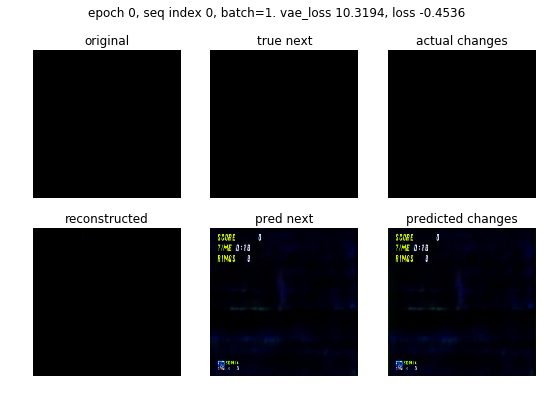

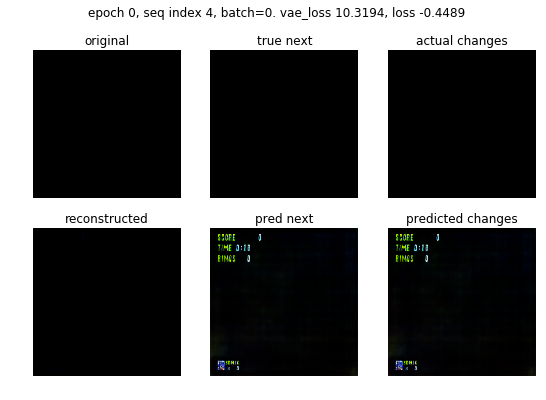

[0/2222] loss_rnn=0.0007, loss_inv= 0.05* 2.7252, loss_vae=0.0001 * (1655.61 + 0.25*|75.74 - 0|)
[400/2222] loss_rnn=0.3152, loss_inv= 0.05* 3.0541, loss_vae=0.0001 * (2537.24 + 0.25*|82.95 - 0|)
[800/2222] loss_rnn=0.3238, loss_inv= 0.05* 3.0491, loss_vae=0.0001 * (2543.88 + 0.25*|81.48 - 0|)
[1200/2222] loss_rnn=0.3198, loss_inv= 0.05* 3.0488, loss_vae=0.0001 * (2444.70 + 0.25*|80.79 - 0|)
[1600/2222] loss_rnn=0.3342, loss_inv= 0.05* 3.0549, loss_vae=0.0001 * (2469.15 + 0.25*|80.35 - 0|)
[2000/2222] loss_rnn=0.3221, loss_inv= 0.05* 3.0566, loss_vae=0.0001 * (2408.76 + 0.25*|79.81 - 0|)
loss_rnn=0.3361, loss_inv= 0.05* 3.0589, loss_vae=0.0001 * (2454.50 + 0.25*|80.15 - 0|)



[0/370] loss_rnn=0.1520, loss_inv= 0.05* 3.1853, loss_vae=0.0001 * (1481.45 + 0.25*|66.61 - 0|)
loss_rnn=0.1941, loss_inv= 0.05* 3.0827, loss_vae=0.0001 * (1734.06 + 0.25*|68.35 - 0|)

Epoch 1, loss=0.3361, loss_val=0.1941, loss_vae=2474.5415, loss_vae_val=1751.1443,  loss_finv=nan, loss_finv_vae=nan, ,


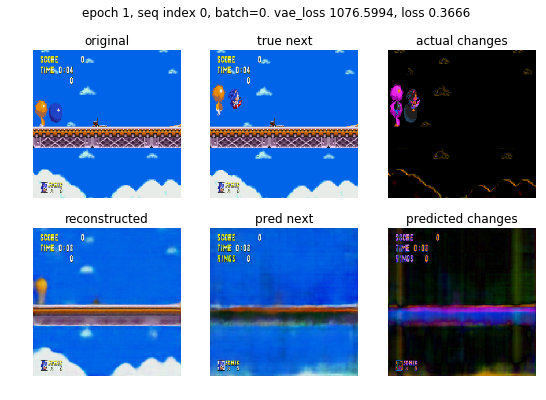

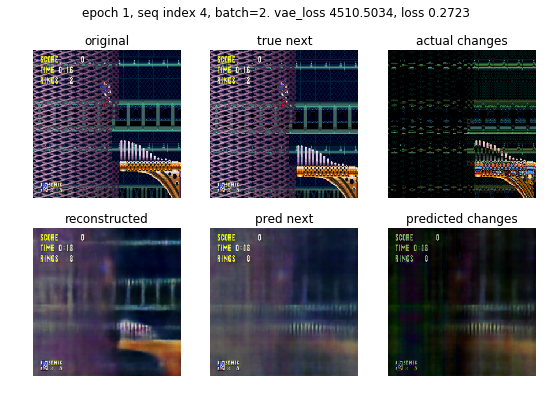

[0/2222] loss_rnn=0.5688, loss_inv= 0.05* 2.4552, loss_vae=0.0001 * (6049.43 + 0.25*|89.79 - 0|)
[400/2222] loss_rnn=0.2833, loss_inv= 0.05* 3.0612, loss_vae=0.0001 * (2316.16 + 0.25*|75.92 - 0|)
[800/2222] loss_rnn=0.3399, loss_inv= 0.05* 3.0640, loss_vae=0.0001 * (2362.89 + 0.25*|79.33 - 0|)
[1200/2222] loss_rnn=0.3520, loss_inv= 0.05* 3.0640, loss_vae=0.0001 * (2375.79 + 0.25*|79.86 - 0|)
[1600/2222] loss_rnn=0.3405, loss_inv= 0.05* 3.0675, loss_vae=0.0001 * (2406.12 + 0.25*|79.88 - 0|)
[2000/2222] loss_rnn=0.3407, loss_inv= 0.05* 3.0723, loss_vae=0.0001 * (2422.43 + 0.25*|79.84 - 0|)
loss_rnn=0.3440, loss_inv= 0.05* 3.0726, loss_vae=0.0001 * (2392.37 + 0.25*|79.95 - 0|)



[0/370] loss_rnn=0.4939, loss_inv= 0.05* 2.9141, loss_vae=0.0001 * (2448.37 + 0.25*|88.49 - 0|)
loss_rnn=0.1613, loss_inv= 0.05* 3.0789, loss_vae=0.0001 * (1848.47 + 0.25*|69.68 - 0|)

Epoch 2, loss=0.3440, loss_val=0.1613, loss_vae=2412.3606, loss_vae_val=1865.8888,  loss_finv=nan, loss_finv_vae=nan, ,


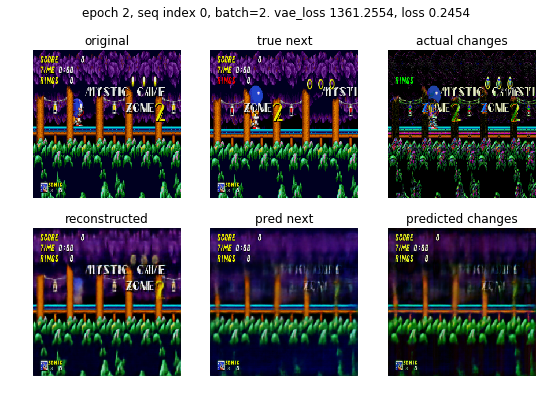

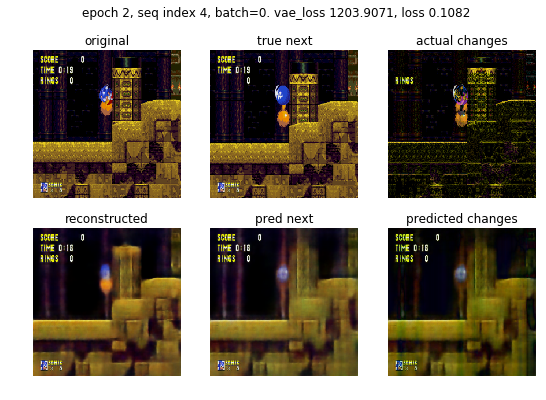

[0/2222] loss_rnn=0.3202, loss_inv= 0.05* 3.0049, loss_vae=0.0001 * (1933.62 + 0.25*|82.95 - 0|)
[400/2222] loss_rnn=0.3257, loss_inv= 0.05* 3.0755, loss_vae=0.0001 * (2312.43 + 0.25*|80.91 - 0|)
[800/2222] loss_rnn=0.3269, loss_inv= 0.05* 3.0600, loss_vae=0.0001 * (2356.43 + 0.25*|80.64 - 0|)
[1200/2222] loss_rnn=0.3232, loss_inv= 0.05* 3.0588, loss_vae=0.0001 * (2296.16 + 0.25*|79.94 - 0|)
[1600/2222] loss_rnn=0.3106, loss_inv= 0.05* 3.0603, loss_vae=0.0001 * (2247.25 + 0.25*|79.71 - 0|)
[2000/2222] loss_rnn=0.3066, loss_inv= 0.05* 3.0650, loss_vae=0.0001 * (2231.78 + 0.25*|79.05 - 0|)
loss_rnn=0.3087, loss_inv= 0.05* 3.0661, loss_vae=0.0001 * (2239.62 + 0.25*|78.76 - 0|)



[0/370] loss_rnn=-0.4419, loss_inv= 0.05* 3.0459, loss_vae=0.0001 * (1.01 + 0.25*|37.26 - 0|)
loss_rnn=0.1873, loss_inv= 0.05* 3.0622, loss_vae=0.0001 * (1899.44 + 0.25*|68.40 - 0|)

Epoch 3, loss=0.3087, loss_val=0.1873, loss_vae=2259.3081, loss_vae_val=1916.5421,  loss_finv=nan, loss_finv_vae=nan, ,


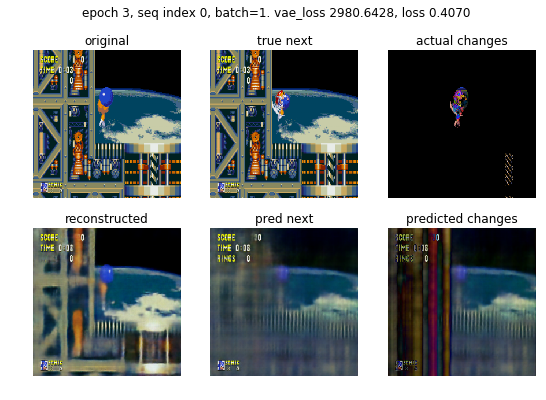

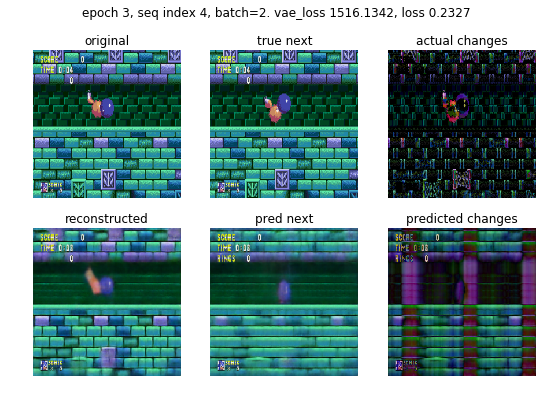

[0/2222] loss_rnn=0.4208, loss_inv= 0.05* 2.7791, loss_vae=0.0001 * (1871.26 + 0.25*|75.01 - 0|)
[400/2222] loss_rnn=0.3750, loss_inv= 0.05* 3.0715, loss_vae=0.0001 * (2543.43 + 0.25*|79.02 - 0|)
[800/2222] loss_rnn=0.3668, loss_inv= 0.05* 3.0640, loss_vae=0.0001 * (2673.96 + 0.25*|82.14 - 0|)
[1200/2222] loss_rnn=0.3403, loss_inv= 0.05* 3.0659, loss_vae=0.0001 * (2527.78 + 0.25*|81.24 - 0|)
[1600/2222] loss_rnn=0.3375, loss_inv= 0.05* 3.0615, loss_vae=0.0001 * (2486.58 + 0.25*|80.33 - 0|)
[2000/2222] loss_rnn=0.3489, loss_inv= 0.05* 3.0642, loss_vae=0.0001 * (2508.51 + 0.25*|80.71 - 0|)
loss_rnn=0.3565, loss_inv= 0.05* 3.0654, loss_vae=0.0001 * (2539.63 + 0.25*|81.18 - 0|)



[0/370] loss_rnn=0.1709, loss_inv= 0.05* 2.6842, loss_vae=0.0001 * (2105.66 + 0.25*|73.74 - 0|)
loss_rnn=0.2940, loss_inv= 0.05* 3.0617, loss_vae=0.0001 * (2271.02 + 0.25*|73.10 - 0|)

Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
Epoch 4, loss=0.3565, loss_val=0.2940, loss_vae=2559.9248, loss_vae_val=2289.2969,  loss_finv=nan, loss_finv_vae=nan, ,


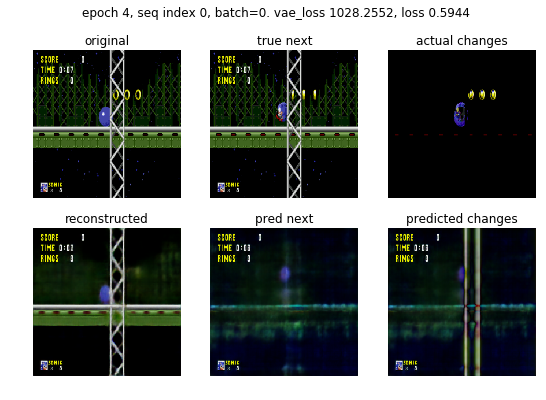

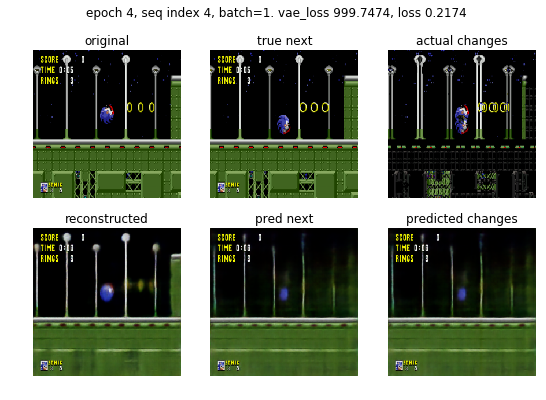

[0/2222] loss_rnn=0.3231, loss_inv= 0.05* 2.9092, loss_vae=0.0001 * (2691.84 + 0.25*|69.36 - 0|)
[400/2222] loss_rnn=0.3419, loss_inv= 0.05* 3.0550, loss_vae=0.0001 * (2094.41 + 0.25*|79.18 - 0|)
[800/2222] loss_rnn=0.3322, loss_inv= 0.05* 3.0533, loss_vae=0.0001 * (2226.40 + 0.25*|79.62 - 0|)
[1200/2222] loss_rnn=0.3304, loss_inv= 0.05* 3.0522, loss_vae=0.0001 * (2285.67 + 0.25*|79.59 - 0|)
[1600/2222] loss_rnn=0.3322, loss_inv= 0.05* 3.0523, loss_vae=0.0001 * (2284.78 + 0.25*|78.84 - 0|)
[2000/2222] loss_rnn=0.3472, loss_inv= 0.05* 3.0519, loss_vae=0.0001 * (2384.04 + 0.25*|79.95 - 0|)
loss_rnn=0.3456, loss_inv= 0.05* 3.0555, loss_vae=0.0001 * (2405.27 + 0.25*|80.14 - 0|)



[0/370] loss_rnn=-0.4381, loss_inv= 0.05* 3.0514, loss_vae=0.0001 * (1.01 + 0.25*|37.26 - 0|)
loss_rnn=0.2706, loss_inv= 0.05* 3.0850, loss_vae=0.0001 * (2340.88 + 0.25*|74.88 - 0|)

Epoch 5, loss=0.3456, loss_val=0.2706, loss_vae=2425.3074, loss_vae_val=2359.6040,  loss_finv=nan, loss_finv_vae=nan, ,


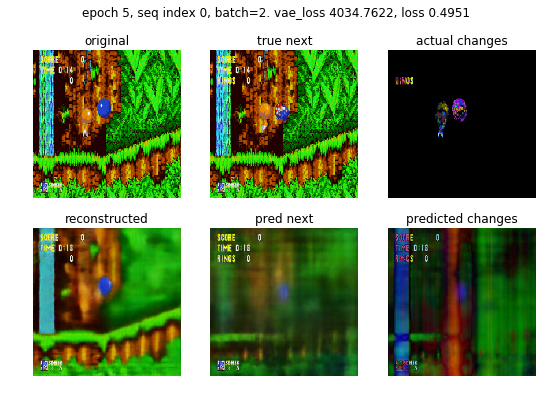

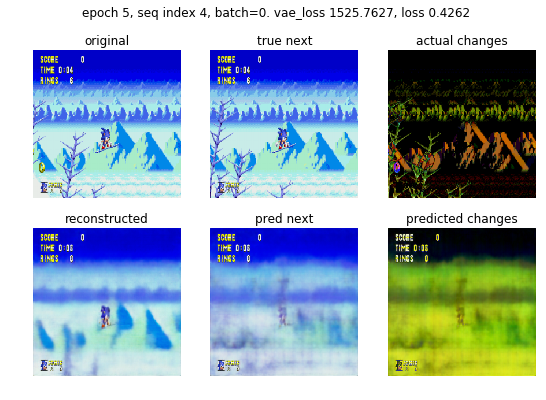

[0/2222] loss_rnn=0.3742, loss_inv= 0.05* 3.0111, loss_vae=0.0001 * (1817.41 + 0.25*|82.15 - 0|)
[400/2222] loss_rnn=0.3476, loss_inv= 0.05* 3.0448, loss_vae=0.0001 * (2359.85 + 0.25*|79.83 - 0|)
[800/2222] loss_rnn=0.3583, loss_inv= 0.05* 3.0500, loss_vae=0.0001 * (2515.30 + 0.25*|80.64 - 0|)
[1200/2222] loss_rnn=0.3296, loss_inv= 0.05* 3.0571, loss_vae=0.0001 * (2396.36 + 0.25*|79.93 - 0|)
[1600/2222] loss_rnn=0.3465, loss_inv= 0.05* 3.0581, loss_vae=0.0001 * (2435.54 + 0.25*|80.01 - 0|)
[2000/2222] loss_rnn=0.3425, loss_inv= 0.05* 3.0598, loss_vae=0.0001 * (2377.07 + 0.25*|79.45 - 0|)
loss_rnn=0.3417, loss_inv= 0.05* 3.0603, loss_vae=0.0001 * (2365.09 + 0.25*|79.42 - 0|)



[0/370] loss_rnn=0.0571, loss_inv= 0.05* 2.8148, loss_vae=0.0001 * (1677.45 + 0.25*|70.48 - 0|)
loss_rnn=0.2996, loss_inv= 0.05* 3.0654, loss_vae=0.0001 * (2120.75 + 0.25*|78.71 - 0|)

Epoch 6, loss=0.3417, loss_val=0.2996, loss_vae=2384.9436, loss_vae_val=2140.4314,  loss_finv=nan, loss_finv_vae=nan, ,


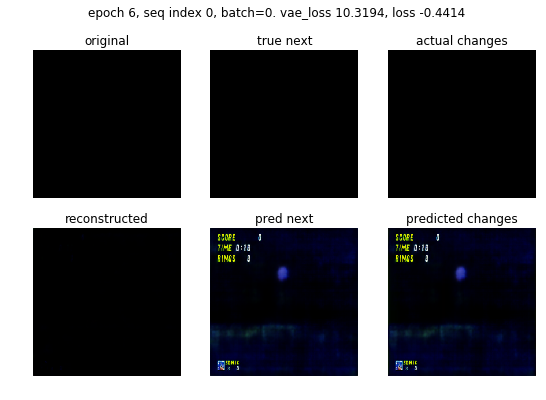

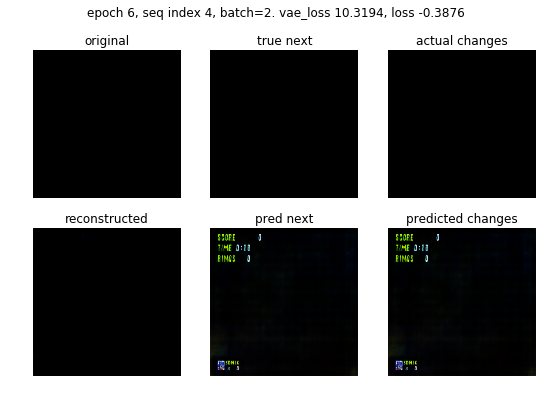

[0/2222] loss_rnn=0.5349, loss_inv= 0.05* 3.3352, loss_vae=0.0001 * (3525.09 + 0.25*|106.99 - 0|)
[400/2222] loss_rnn=0.2689, loss_inv= 0.05* 3.0874, loss_vae=0.0001 * (2090.83 + 0.25*|76.41 - 0|)
[800/2222] loss_rnn=0.3012, loss_inv= 0.05* 3.0757, loss_vae=0.0001 * (2238.29 + 0.25*|78.01 - 0|)
[1200/2222] loss_rnn=0.3224, loss_inv= 0.05* 3.0747, loss_vae=0.0001 * (2342.03 + 0.25*|78.48 - 0|)
[1600/2222] loss_rnn=0.3356, loss_inv= 0.05* 3.0736, loss_vae=0.0001 * (2324.99 + 0.25*|79.40 - 0|)
[2000/2222] loss_rnn=0.3403, loss_inv= 0.05* 3.0689, loss_vae=0.0001 * (2390.62 + 0.25*|79.63 - 0|)
loss_rnn=0.3409, loss_inv= 0.05* 3.0678, loss_vae=0.0001 * (2385.00 + 0.25*|80.08 - 0|)



[0/370] loss_rnn=0.4255, loss_inv= 0.05* 3.1346, loss_vae=0.0001 * (1678.84 + 0.25*|85.67 - 0|)
loss_rnn=0.2066, loss_inv= 0.05* 3.0658, loss_vae=0.0001 * (1670.65 + 0.25*|68.16 - 0|)

Epoch 7, loss=0.3409, loss_val=0.2066, loss_vae=2405.0212, loss_vae_val=1687.6959,  loss_finv=nan, loss_finv_vae=nan, ,


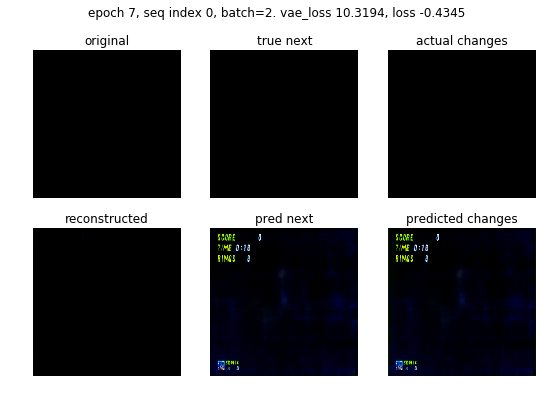

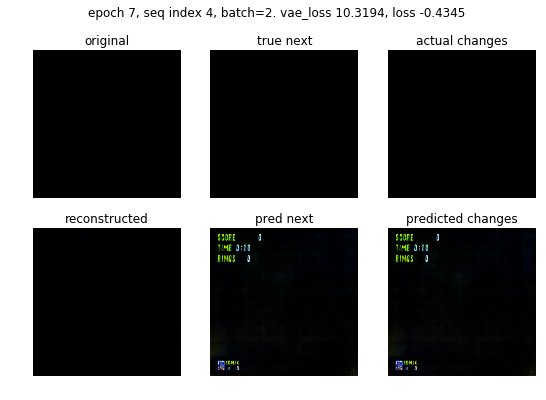

[0/2222] loss_rnn=0.3750, loss_inv= 0.05* 3.0112, loss_vae=0.0001 * (1412.63 + 0.25*|81.10 - 0|)
[400/2222] loss_rnn=0.3343, loss_inv= 0.05* 3.0748, loss_vae=0.0001 * (2520.42 + 0.25*|79.05 - 0|)
[800/2222] loss_rnn=0.3077, loss_inv= 0.05* 3.0694, loss_vae=0.0001 * (2339.36 + 0.25*|77.63 - 0|)
[1200/2222] loss_rnn=0.3246, loss_inv= 0.05* 3.0706, loss_vae=0.0001 * (2363.15 + 0.25*|78.48 - 0|)
[1600/2222] loss_rnn=0.3419, loss_inv= 0.05* 3.0664, loss_vae=0.0001 * (2504.89 + 0.25*|80.43 - 0|)


In [ ]:
for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}, loss_vae={:2.4f}, loss_vae_val={:2.4f},  loss_finv={:2.4f}, loss_finv_vae={:2.4f}, ,'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae']),
        np.mean(info['loss_finv']),
        np.mean(info_val['loss_finv'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), f'./models/{NAME}-mdnrnn_{epoch}_state_dict.pkl')
    torch.save(vae.state_dict(), f'./models/{NAME}-vae_{epoch}_state_dict.pkl')
    torch.save(finv.state_dict(), f'./models/{NAME}-finv_{epoch}_state_dict.pkl')
    
    # Tidy
    torch.cuda.empty_cache()

In [ ]:
 0 : loss_rnn=0.8469, loss_inv= 0.05* 3.0640, loss_vae=0.0002 * (5675.53 + 0.25*|187.17 - 0|): 100% 39996/39996 [20:49<00:00, 30.09it/s]
12 : loss_rnn=0.8245, loss_inv= 0.05* 3.0653, loss_vae=0.0002 * (5599.32 + 0.25*|169.97 - 0|): 100% 39996/39996 [23:19<00:00, 27.29it/s]

In [35]:
[0/2222] loss_rnn=0.5202, loss_inv= 0.05* 3.5130, loss_vae=0.0002 * (2349.06 + 0.25*|90.06 - 0|)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
[400/2222] loss_rnn=0.3558, loss_inv= 0.05* 3.0632, loss_vae=0.0002 * (2601.81 + 0.25*|79.25 - 0|)
[800/2222] loss_rnn=0.3687, loss_inv= 0.05* 3.0716, loss_vae=0.0002 * (2643.50 + 0.25*|82.61 - 0|)
[1200/2222] loss_rnn=0.3741, loss_inv= 0.05* 3.0649, loss_vae=0.0002 * (2665.00 + 0.25*|83.70 - 0|)
2: loss_rnn=0.3440, loss_inv= 0.05* 3.0725, loss_vae=0.0001 * (2392.31 + 0.25*|79.96 - 0|): 100% 39996/39996 [23:19<00:00, 30.05it/s]
5: loss_rnn=0.3456, loss_inv= 0.05* 3.0552, loss_vae=0.0001 * (2405.27 + 0.25*|80.15 - 0|): 100% 39996/39996 
6: loss_rnn=0.3417, loss_inv= 0.05* 3.0606, loss_vae=0.0001 * (2365.09 + 0.25*|79.42 - 0|): 100% 39996/39996 [21:22<00:00, 27.46

0.15000000000000002

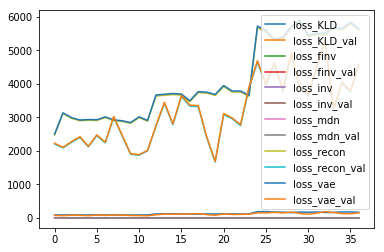

In [24]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()

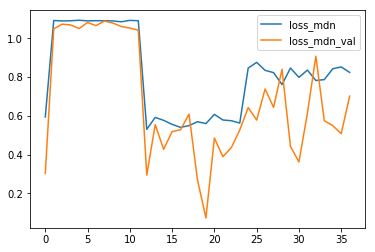

In [25]:
df_history[['loss_mdn','loss_mdn_val']].plot()

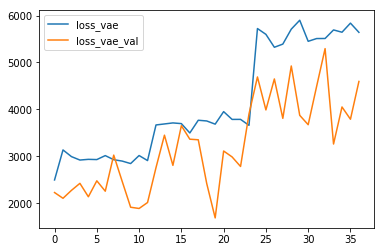

In [26]:
df_history[['loss_vae','loss_vae_val']].plot()

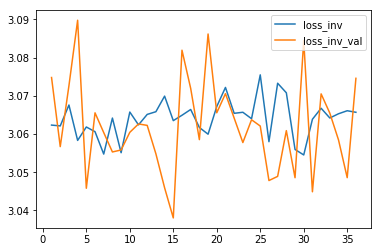

In [27]:
df_history[['loss_inv','loss_inv_val']].plot()

## Save

In [ ]:
torch.save(mdnrnn.state_dict(), f'./models/{NAME}-mdnrnn_state_dict.pkl')
torch.save(vae.state_dict(), f'./models/{NAME}-vae_state_dict.pkl')
torch.save(finv.state_dict(), f'./models/{NAME}-finv_state_dict.pkl')
df_history.to_csv(f'./models/{NAME}.csv', index=False)

torch.save(mdnrnn, f'./models/{NAME}-mdnrnn.pkl')
torch.save(vae, f'./models/{NAME}-vae')
torch.save(finv.state_dict(), f'./models/{NAME}-finv.pkl')

## View

In [ ]:
plot_results(loader_test, n=4, epoch=0)

In [ ]:
plot_results(loader_train, n=4, epoch=0)

In [ ]:
torch.cuda.empty_cache()